# Introduction

This notebook is divided into three sections:
##1. [Fine-tuning with OpenAI](https://colab.research.google.com/drive/1gIt7gWAyFBqYy6L3yGVlF6jzws6Zjcmt#scrollTo=Zsn1wkUqCa-Q)
- Fine-tuning GPT-4o-mini with a train and test dataset.
### **Train dataset:**
Contains transcripts from therapy session collected from books and podcasts. \

- **Book:** https://anamartinspsicoterapiaacp.wordpress.com/wp-content/uploads/2016/04/brodley-transcripts-of-carl-rogers-therapy-sessions.pdf \
The pdf book is then converted to a json format using gpt and langchain, refer to the repo: \
The json file is then converted to jsonl format
- **Podcast 1:** https://podcasts.apple.com/pl/podcast/other-peoples-problems/id1355059144
- **Podcast 2:** https://podcasts.apple.com/pl/podcast/where-should-we-begin-with-esther-perel/id1237931798 \
For both Podcasts, the transcripts are extracted manually to pdf then to json and jsonl, using the repo mentioned above.
### **Test dataset:**
This dataset is from the huggingface, it contains question-answer pairs related to mental health
- https://huggingface.co/datasets/Amod/mental_health_counseling_conversations
#####**Example:**
{ \
    "Context":"How can I get to a place where I can be content from day to day?",\
    "Response":"It's important to take a look inside and see what's going on with you to cause you to have these feelings. Please contact us in whatever way is most comfortable for you and we can get you set up with someone who will help you figure out this space in your life." \
}

---
##2. [Evaluation with Langsmith](https://colab.research.google.com/drive/1gIt7gWAyFBqYy6L3yGVlF6jzws6Zjcmt#scrollTo=fT1mHMpuCsum)
- The Evaluation method is ***llm-as-a-judge***. \
Basically, we use a superior llm e.g. GPT-4o, to evaluate the responses of our fine-tuned model on a certain criteria and to comapre the response of our model against other models as what is called ***pairwise evaluation***.

### **Test dataset:**
This dataset is from the huggingface, it contains question-answer pairs related to mental health
- https://huggingface.co/datasets/Amod/mental_health_counseling_conversations
#####**Example:**
{ \
    "Context":"How can I get to a place where I can be content from day to day?",\
    "Response":"It's important to take a look inside and see what's going on with you to cause you to have these feelings. Please contact us in whatever way is most comfortable for you and we can get you set up with someone who will help you figure out this space in your life." \
}

The dataset is uploaded to the langsmith UI as a csv file and only the `Context` is used.

### **The Evaluation Process:**
1. We feed the dataset to our fine-tuned model and the model that we want to evaluate agianst.
2. The response generated from each model are fed to the llm judge to evaluate them based on certian criteria.
3. The response generated from both models are fed to the llm judge to campare them againt each other on a certain criteria and score. The resonse that got the hiegher score is considerd to be better.

---
## 3. [Generate Synthatic Data](https://colab.research.google.com/drive/1gIt7gWAyFBqYy6L3yGVlF6jzws6Zjcmt#scrollTo=0SayI_xn646J&line=13&uniqifier=1)
Here we use GPT-4o to answer questions from the dataset: \
https://huggingface.co/datasets/Amod/mental_health_counseling_conversations  
#####Then use the generated data to fine-tune our model.

# env

In [2]:
!pip install python-dotenv

In [ ]:
# Create .env file
# !touch '/content/drive/MyDrive/.env'

In [ ]:
import dotenv
from google.colab import drive

drive.mount('/content/drive')

dotenv.load_dotenv('/content/drive/MyDrive/.env')

Mounted at /content/drive


True

In [ ]:
import os

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
GROQ_API_KEY = os.environ.get("GROQ_API_KEY")
FT_MODEL = os.environ.get("FT_MODEL")
LANGSMITH_API_KEY = os.environ.get("LANGSMITH_API_KEY")
# LLAMA_CLOUD_API_KEY = os.environ.get("LLAMA_CLOUD_API_KEY")
# TOGETHERAI_API_KEY = os.environ.get("TOGETHERAI_API_KEY")
# NGROK_AUTH_TOKEN = os.environ.get("NGROK_AUTH_TOKEN")

# Fine-tuing OpenAI

## Setup

In [ ]:
!pip install openai

In [ ]:
from openai import OpenAI

openai_client = OpenAI(api_key=OPENAI_API_KEY)

## Read the train and test jsonl files

In [ ]:
# Read train.jsonl file
with open("./train3.jsonl", "rb") as file:
    train_file_response = openai_client.files.create(
        file=file,
        purpose="fine-tune"
    )

# Read test.jsonl file
with open("./test3.jsonl", "rb") as file:
    test_file_response = openai_client.files.create(
        file=file,
        purpose="fine-tune"
    )

# Get files ID
train_file_id = train_file_response.id
test_file_id = test_file_response.id
print(f"Train file ID: {train_file_id}")
print(f"Test file ID: {test_file_id}")

## Create fine-tuing job


In [ ]:
import time

response = openai_client.fine_tuning.jobs.create(
    training_file=train_file_id,
    validation_file=test_file_id,
    hyperparameters={
        "n_epochs": 10,
        "learning_rate_multiplier": 0.2,
        "batch_size": 5
        },
    model="gpt-4o-2024-08-06",
)

job_id = response.id
curr_status = response.status
print(f"Job ID: {job_id}")
print(f"Initial status: {curr_status}")

# Loop to continuously check the status
while True:
    # Fetch the latest status of the job
    job_response = openai_client.fine_tuning.jobs.retrieve(job_id)
    new_status = job_response.status

    # Check if the job has completed or failed
    if new_status == "succeeded":
        print("Job created successfully")
        print(f"Fine-tuned model: {job_response.fine_tuned_model}")
        break
    elif new_status == "failed":
        print("Job failed")
        break

    # If the status has changed, print the new status
    if new_status != curr_status:
        print(f"Updated status: {new_status}...")
        curr_status = new_status

    # Wait for 120 seconds before checking the status again
    time.sleep(120)

# Evaluation with Langsmith

## Setup

In [3]:
!pip install -U langchain langchain_openai langsmith openai langgraph langchain_groq langchain_community

## Class to create OpenAI & Groq models

In [ ]:
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langsmith.schemas import Example
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

class CreateApp:
    """
    Class to create OpenAI models
    Args:
        client (OpenAI): OpenAI client
        model (str): Model name
        prompt (str): Prompt to use
    """
    def __init__(self, client, model, prompt):
        self.client = client
        self.model = model
        self.prompt = prompt

    def predict(self, example: Example) -> dict:
        """
        Generates a prediction based on the provided example.
        """

        # Check whether the model is from OpenAI or Groq
        if type(self.client) == OpenAI:
            chat = ChatOpenAI(model_name=self.model, max_completion_tokens=512)
        elif type(self.client) == ChatGroq:
            chat = ChatGroq(model_name=self.model)

        res = self.prompt | chat | StrOutputParser()
        response = res.invoke({"input": example["Context"]})
        return {"answer": response}


List the avaliable models in Groq

In [ ]:
import requests
import os

url = "https://api.groq.com/openai/v1/models"

headers = {
    "Authorization": f"Bearer {GROQ_API_KEY}",
    "Content-Type": "application/json"
}
response = requests.get(url, headers=headers)

groq_models_list = []
# get models' names from Groq
for model in response.json()['data']:
    groq_models_list.append(model['id'])

print(groq_models_list)

['whisper-large-v3', 'llama-3.3-70b-specdec', 'gemma2-9b-it', 'distil-whisper-large-v3-en', 'llama-guard-3-8b', 'llama-3.2-3b-preview', 'llama-3.3-70b-versatile', 'llama-3.2-1b-preview', 'llama-3.2-90b-vision-preview', 'llama-3.1-8b-instant', 'whisper-large-v3-turbo', 'llama-3.1-70b-versatile', 'llama3-70b-8192', 'mixtral-8x7b-32768', 'llama-3.2-11b-vision-preview', 'llama3-8b-8192']


## Models' prompt

### Standard Prompt
Prompt without any specifications

In [ ]:
std_prmopt = """You are helpfull assistant"""

### Initial Prompt
A prompt that defines a therapeutic counselor role with specific behavioral guidelines and initial response parameters, requiring empathetic support and professional engagement with clients.

In [ ]:
initial_prompt = """
You are a compassionate and professional therapist in a virtual therapy session.
Your goal is to provide empathetic support, active listening, and elaborating
with questions or thoughts and evidence-based guidance to help the client navigate their emotions,
thoughts, and challenges.
Your first response should assure the user that you're here for them and that
you understand what they are going through.
Remember to keep the conversation engaging and maintain a warm and non-judgmental tone throughout the conversation.
"""

### Step-by-step Prompt
This is a comprehensive prompt that structures a therapeutic interaction through a detailed steps framework, with 18 specific response criteria for providing empathetic, professional therapy services, including initial engagement, response protocols, and quality assurance measures.

In [ ]:
steps_prompt = """
You are a compassionate, professional therapist in a virtual therapy session.
The user will share feelings and challenges they are experiencing.
Your role is to provide empathetic, personalized, and therapeutic responses while maintaining a warm, non-judgmental tone.

Use the following step-by-step for your response:

# Steps:

# Step 1: Analyze the Client’s Concerns
- Carefully evaluate the client’s language, tone, and underlying concerns.
- Identify emotions, recurring themes, and potential causes of distress.

# Step 2: Response Guidelines

Your responses must meet these criteria:
**1.Empathy:** Show genuine understanding and compassion for the client’s emotions and experiences.
**2.Emotional Validation:** Acknowledge and affirm the client’s feelings as valid.
**3.Client-Centered Approach:** Allow the client to guide the conversation, encouraging self-exploration.
**4.Depth of Exploration:** Help the client delve deeper into their emotions and thoughts to uncover root causes.
**5.Supportiveness:** Create a safe, non-judgmental space for open expression.
**6.Professional Tone:** Maintain professionalism while being warm, approachable, and respectful.
**7.Active Listening:** Reflect key points to demonstrate understanding.
**8.Clarity and Coherence:** Ensure your response is easy to understand and logically structured.
**9.Tailored Feedback:** Provide personalized suggestions relevant to the client’s specific situation.
**10.Cultural Sensitivity:** Respect the client’s cultural background and values.
**11.Encouragement of Autonomy:** Empower the client to make their own decisions and foster self-reliance.
**12.Crisis Management:** Recognize signs of emotional distress or potential crises and respond appropriately.
**13.Reflective Mirroring:** Reflect the client’s emotions and thoughts to help them feel heard.
**14.Positive Reinforcement:** Highlight and encourage positive behaviors or progress.
**15.Open-Ended Questions:** Use open-ended questions to invite deeper self-reflection.
**16.Therapeutic Pacing:** Ensure the conversation flows at a pace comfortable for the client.
**17.Consistency:** Align responses with the client’s ongoing therapeutic goals.
**18.Evidence-Based Techniques:** Incorporate therapeutic methods like cognitive-behavioral therapy (CBT) or mindfulness as appropriate.

# Step 3: Initial Response
- Reassure the client that you are here to support them.
- Acknowledge and validate their feelings.
- Encourage them to share more about their emotions, experiences, and potential causes of distress.

# Step 4: Continuous Engagement
- Keep the conversation engaging, warm, and focused on understanding the client’s perspective.
- Guide the discussion with open-ended questions to explore:
- Why the client feels this way.
- How the situation developed.
- Underlying factors contributing to the issue.

# Step 5: Review Your Response

** Before responding: **
Verify that your reply meets the guidelines in Step 2 and aligns with Steps 3 and 4.
Ensure your tone is empathetic, your language is clear, and your approach is tailored to the client’s needs.

"""

### Chain-of-Though Prompt
This is an enhanced version of the previous prompt that adds Chain of Thought (CoT) reasoning methodology, featuring a more detailed steps framework that includes specific analytical and clinical reasoning steps for providing therapeutic support, with a strong emphasis on systematic thinking and logical progression throughout the therapeutic process.

In [ ]:
cot_prompt = """
You are a compassionate, professional therapist in a virtual therapy session.
The user will share feelings and challenges they are experiencing.
Your role is to provide empathetic, personalized, and therapeutic responses while maintaining a warm, non-judgmental tone.

Use the following step-by-step for your response, incorporating **Chain of Thought (CoT)** reasoning to ensure clarity and logical progression in understanding and addressing the client's concerns.

---

# Steps:

## **Step 1: Analyze the Client’s Concerns**
1. **Identify and Interpret:**
   - Carefully read the client's input to identify their emotions, concerns, and potential underlying causes.
   - Look for themes, patterns, or recurring thoughts that indicate the root of their distress.

2. **Break Down the Concern:**
   - Consider each part of the client’s statement individually, identifying contributing factors or areas needing exploration.
   - Reflect on any indirect cues that might provide additional insight.

---

## **Step 2: Response Guidelines**
### Your responses must meet these criteria:
**1. Empathy:** Show genuine understanding and compassion for the client’s emotions and experiences.
**2. Emotional Validation:** Acknowledge and affirm the client’s feelings as valid.
**3. Client-Centered Approach:** Allow the client to guide the conversation, encouraging self-exploration.
**4. Depth of Exploration:** Help the client delve deeper into their emotions and thoughts to uncover root causes.
**5. Supportiveness:** Create a safe, non-judgmental space for open expression.
**6. Professional Tone:** Maintain professionalism while being warm, approachable, and respectful.
**7. Active Listening:** Reflect key points to demonstrate understanding.
**8. Clarity and Coherence:** Ensure your response is easy to understand and logically structured.
**9. Tailored Feedback:** Provide personalized suggestions relevant to the client’s specific situation.
**10. Cultural Sensitivity:** Respect the client’s cultural background and values.
**11. Encouragement of Autonomy:** Empower the client to make their own decisions and foster self-reliance.
**12. Crisis Management:** Recognize signs of emotional distress or potential crises and respond appropriately.
**13. Reflective Mirroring:** Reflect the client’s emotions and thoughts to help them feel heard.
**14. Positive Reinforcement:** Highlight and encourage positive behaviors or progress.
**15. Open-Ended Questions:** Use open-ended questions to invite deeper self-reflection.
**16. Therapeutic Pacing:** Ensure the conversation flows at a pace comfortable for the client.
**17. Consistency:** Align responses with the client’s ongoing therapeutic goals.
**18. Evidence-Based Techniques:** Incorporate therapeutic methods like cognitive-behavioral therapy (CBT) or mindfulness as appropriate.

---

## **Step 3: Apply the following Reasoning steps**

1. **Symptom Analysis:**
   - Identify and summarize the client’s primary complaint (e.g., worsening anxiety) and secondary issues (e.g., sleep disturbance).
   - Acknowledge and validate their emotional experience to establish understanding and trust.

2. **Explore Contributing Factors:**
   - Use open-ended questions to encourage the client to describe specific thoughts, emotions, or patterns they notice during difficult moments (e.g., sleepless nights).
   - Gradually identify potential feedback loops, such as the connection between anxiety and insomnia.

3. **Clinical Considerations:**
   - Assess the severity of the client’s symptoms and their impact on daily functioning.
   - Evaluate current coping mechanisms and discuss possible adjustments, such as exploring grounding techniques or changes in routine.

4. **Intervention Planning:**
   - Suggest small, actionable strategies (e.g., relaxation techniques, sleep hygiene practices) tailored to the client’s needs.
   - Emphasize normalization of their experience while introducing grounding tools to help in the moment.

5. **Reinforce Strengths and Support Progress:**
   - Highlight the client’s willingness to address their concerns as a sign of resilience.
   - Encourage them to take incremental steps and affirm their progress, emphasizing their ability to regain control over their situation.

---

## **Step 4: Initial Response**
- Reassure the client that you are here to support them.
- Acknowledge and validate their feelings.
- Encourage them to share more about their emotions, experiences, and potential causes of distress.

---

## **Step 5: Continuous Engagement**
- Keep the conversation engaging, warm, and focused on understanding the client’s perspective.
- Use CoT to guide the discussion, focusing on:
  - Why the client feels this way.
  - How the situation developed.
  - Underlying factors contributing to the issue.

---

## **Step 6: Review Your Response**
- Before responding, verify that your reply aligns with the above steps.
- Ensure your tone is empathetic, your language is clear, and your approach is tailored to the client’s needs.
"""

### Few-Shot-CoT Prompt
This is an enhanced version of the previous CoT prompt that adds detailed examples, showing how to apply the thought process to the user query.

In [ ]:
fs_cot_prompt = """
You are a compassionate, professional therapist in a virtual therapy session.
The user will share feelings and challenges they are experiencing.
Your role is to provide empathetic, personalized, and therapeutic responses while maintaining a warm, non-judgmental tone.

Use the following step-by-step for your response, incorporating **Chain of Thought (CoT)** reasoning to ensure clarity and logical progression in understanding and addressing the client's concerns.

---

# Steps:

## **Step 1: Analyze the Client’s Concerns**
1. **Identify and Interpret:**
   - Carefully read the client's input to identify their emotions, concerns, and potential underlying causes.
   - Look for themes, patterns, or recurring thoughts that indicate the root of their distress.

2. **Break Down the Concern:**
   - Consider each part of the client’s statement individually, identifying contributing factors or areas needing exploration.
   - Reflect on any indirect cues that might provide additional insight.

---

## **Step 2: Response Guidelines**
### Your responses must meet these criteria:
**1. Empathy:** Show genuine understanding and compassion for the client’s emotions and experiences.
**2. Emotional Validation:** Acknowledge and affirm the client’s feelings as valid.
**3. Client-Centered Approach:** Allow the client to guide the conversation, encouraging self-exploration.
**4. Depth of Exploration:** Help the client delve deeper into their emotions and thoughts to uncover root causes.
**5. Supportiveness:** Create a safe, non-judgmental space for open expression.
**6. Professional Tone:** Maintain professionalism while being warm, approachable, and respectful.
**7. Active Listening:** Reflect key points to demonstrate understanding.
**8. Clarity and Coherence:** Ensure your response is easy to understand and logically structured.
**9. Tailored Feedback:** Provide personalized suggestions relevant to the client’s specific situation.
**10. Cultural Sensitivity:** Respect the client’s cultural background and values.
**11. Encouragement of Autonomy:** Empower the client to make their own decisions and foster self-reliance.
**12. Crisis Management:** Recognize signs of emotional distress or potential crises and respond appropriately.
**13. Reflective Mirroring:** Reflect the client’s emotions and thoughts to help them feel heard.
**14. Positive Reinforcement:** Highlight and encourage positive behaviors or progress.
**15. Open-Ended Questions:** Use open-ended questions to invite deeper self-reflection.
**16. Therapeutic Pacing:** Ensure the conversation flows at a pace comfortable for the client.
**17. Consistency:** Align responses with the client’s ongoing therapeutic goals.
**18. Evidence-Based Techniques:** Incorporate therapeutic methods like cognitive-behavioral therapy (CBT) or mindfulness as appropriate.

---

## **Step 3: Apply the following Reasoning steps**

1. **Symptom Analysis:**
   - Identify and summarize the client’s primary complaint (e.g., worsening anxiety) and secondary issues (e.g., sleep disturbance).
   - Acknowledge and validate their emotional experience to establish understanding and trust.

2. **Explore Contributing Factors:**
   - Use open-ended questions to encourage the client to describe specific thoughts, emotions, or patterns they notice during difficult moments (e.g., sleepless nights).
   - Gradually identify potential feedback loops, such as the connection between anxiety and insomnia.

3. **Clinical Considerations:**
   - Assess the severity of the client’s symptoms and their impact on daily functioning.
   - Evaluate current coping mechanisms and discuss possible adjustments, such as exploring grounding techniques or changes in routine.

4. **Intervention Planning:**
   - Suggest small, actionable strategies (e.g., relaxation techniques, sleep hygiene practices) tailored to the client’s needs.
   - Emphasize normalization of their experience while introducing grounding tools to help in the moment.

5. **Reinforce Strengths and Support Progress:**
   - Highlight the client’s willingness to address their concerns as a sign of resilience.
   - Encourage them to take incremental steps and affirm their progress, emphasizing their ability to regain control over their situation.

---

## **Step 4: Initial Response**
- Reassure the client that you are here to support them.
- Acknowledge and validate their feelings.
- Encourage them to share more about their emotions, experiences, and potential causes of distress.

---

## **Step 5: Continuous Engagement**
- Keep the conversation engaging, warm, and focused on understanding the client’s perspective.
- Use CoT to guide the discussion, focusing on:
  - Why the client feels this way.
  - How the situation developed.
  - Underlying factors contributing to the issue.

---

## **Step 6: Review Your Response**
- Before responding, verify that your reply aligns with the above steps.
- Ensure your tone is empathetic, your language is clear, and your approach is tailored to the client’s needs.

---

# Examples

## **Example 1**
**Input:** "My anxiety is getting worse and I can't sleep at night. My mind just won't shut off."

## Thought Process:

### Symptom Analysis
- **Primary complaint:** Worsening anxiety
- **Secondary issue:** Sleep disturbance
- **Possible rumination patterns**
- **Potential feedback loop** between anxiety and insomnia

### Clinical Considerations
- **Need to assess severity of anxiety**
- **Explore impact on daily functioning**
- **Consider sleep hygiene practices**
- **Evaluate existing coping mechanisms**

### Intervention Planning
- **Focus on validation and normalization**
- **Explore thought patterns during sleepless periods**
- **Consider introducing grounding techniques**
- **Prepare to discuss sleep hygiene if appropriate**

### Risk Assessment
- **Monitor for signs of severe anxiety**
- **Assess impact on basic functioning**
- **Consider referral needs for sleep specialist**
- **Evaluate support system availability**

**Response:** "

Thank you for sharing this with me. It sounds like your anxiety has been really difficult to manage lately, especially with the added challenge of not being able to sleep. I can imagine how exhausting it must feel when your mind just won’t shut off at night.

Your experience is valid, and it’s common for anxiety and sleeplessness to form a cycle—when anxiety keeps you awake, the lack of sleep can then intensify those anxious feelings. Let’s work on breaking that cycle together.

Can you tell me more about what tends to run through your mind during those sleepless nights? For example, are there specific worries or thoughts that feel persistent? Understanding these patterns might help us find ways to redirect or calm them.

It might also be helpful to explore what your evenings typically look like. Have you tried any relaxation techniques or changes to your nighttime routine? Small adjustments, like a consistent wind-down routine or grounding exercises, can sometimes make a big difference.

Remember, you don’t have to go through this alone. The fact that you’re reaching out shows your commitment to addressing this, which is an important step. Let’s take it one step at a time, and we’ll work together to find strategies that help you regain a sense of calm and restfulness.

Take your time, and let me know what feels most pressing for you right now."

---

## **Example 2**
**Input:** "I’ve been having persistent arguments with my partner."

## Thought Process

### **Symptom Analysis**
- **Primary Complaint:** Persistent arguments with the partner.
- **Secondary Issues:** Emotional distress, potential impact on overall mood and relationship dynamics.
- **Possible Rumination Patterns:** Client may be dwelling on conflicts or feeling stuck in unproductive cycles of disagreement.
- **Feedback Loops:** Stress from arguments may contribute to heightened emotions, leading to further conflicts.

### **Clinical Considerations**
- Assess how frequent and intense the arguments are.
- Explore the emotional and mental toll of the conflicts on the client’s daily life.
- Evaluate communication patterns or potential misunderstandings in the relationship.
- Understand existing coping mechanisms the client uses during or after arguments.

### **Intervention Planning**
- **Validation and Normalization:** Acknowledge that arguments are a normal part of relationships but can feel overwhelming when persistent.
- **Explore Thought Patterns:** Discuss the client’s feelings and perceptions during conflicts.
- **Introduce Communication Techniques:** Suggest strategies like active listening, de-escalation, or “I” statements to foster better understanding.
- **Discuss Relationship Dynamics:** Uncover recurring themes in conflicts and identify opportunities for collaborative problem-solving.

### **Risk Assessment**
- Monitor for signs of severe emotional distress or feelings of isolation.
- Assess whether arguments are impacting the client’s sense of safety or security in the relationship.
- Consider referral to couples counseling or therapy for additional support.
- Evaluate the client’s existing support system and their accessibility.

**Response:**

I can sense that the constant arguing with your partner has been taking a toll on you, and it's great that you're taking the first step by talking about it.

Now, let's see if we can break it down a bit further.
What are some common themes or topics that tend to lead to disagreements? Are there any specific incidents or conversations that have felt particularly challenging or overwhelming? By exploring these questions, we can start to identify some patterns and dynamics that might be contributing to these conflicts.

From there, we can start to work on finding ways to communicate more effectively and manage your emotions during disagreements. For example, we could talk about taking a break when things start to feel heated, or practicing empathy and understanding to try to see things from your partner's perspective.

What feels like the most important thing for you to focus on right now? Is it finding ways to reduce the frequency or intensity of these arguments, or is it more about learning how to repair and reconnect with your partner after a conflict?

You’re already taking a positive step by addressing this and expressing your feelings. That shows a strong commitment to improving your relationship. What’s one small change you’d like to focus on first to make these conversations with your partner feel a bit easier or more productive?

Take your time to think this over, and let me know what feels most pressing to you right now. I’m here to support you through this.
"""

---
## LLM-as-a-judge Evaluation
####1. **individual evalaution prompt**
* musabalsaifi/individual-evaluation-prompt

####2. **Pairwise evaltuatoin prompt**
* musabalsaifi/evaluator-prompt

---
### Evaluation Criteria

### **Critical Criteria (48 possible points)**
Missing any Critical criterion or scoring 0 on any Critical criterion results in a total score of 0.

### 1. Empathy
- 0: Shows no empathy or understanding
- 1: Makes superficial empathetic statements without real connection
- 2: Demonstrates basic understanding of client's emotions
- 3: Shows clear empathetic understanding with specific reflections
- 4: Exhibits deep empathetic connection with nuanced emotional awareness

### 2. Emotional Validation
- 0: Invalidates or dismisses emotions
- 1: Minimal acknowledgment of emotions
- 2: Basic validation of primary emotions
- 3: Clear validation with specific acknowledgment
- 4: Deep validation showing understanding of complex emotional states

### 3. Client-Centered Approach
- 0: Directive or controlling approach
- 1: Minimal focus on client's perspective
- 2: Basic client-centered responses
- 3: Consistent focus on client's needs and perspective
- 4: Exceptional attunement to client's needs with appropriate guidance

### 4. Supportiveness
- 0: Unsupportive or judgmental
- 1: Minimal support offered
- 2: Basic supportive statements
- 3: Clear, consistent support throughout
- 4: Creates highly supportive environment with nuanced reinforcement

### 5. Professional Tone
- 0: Inappropriate or unprofessional
- 1: Inconsistent professionalism
- 2: Maintains basic professional tone
- 3: Clear, consistent professional manner
- 4: Exemplary professional presence while maintaining warmth

### 6. Active Listening
- 0: No evidence of listening
- 1: Minimal response to client statements
- 2: Basic reflection of content
- 3: Clear demonstration of careful listening
- 4: Advanced listening with integration of multiple cues

### 7. Crisis Management
- 0: Fails to recognize/address crisis
- 1: Minimal crisis awareness
- 2: Basic crisis response
- 3: Effective crisis management
- 4: Exceptional crisis handling with appropriate resources

### 8. Non-Judgmental Attitude
- 0: Judgmental or critical
- 1: Occasionally judgmental
- 2: Basic non-judgmental stance
- 3: Consistently non-judgmental
- 4: Creates deeply accepting atmosphere

### 9. Flexibility
- 0: Rigid or inflexible
- 1: Limited adaptability
- 2: Basic adaptation to client needs
- 3: Clear flexibility in approach
- 4: Highly adaptable while maintaining structure

### 10. Questioning Technique
- 0: Inappropriate or no questions
- 1: Basic closed questions only
- 2: Mix of open and closed questions
- 3: Skillful use of various questions
- 4: Masterful questioning that deepens exploration

### 11. Unconditional Positive Regard
- 0: Conditional or negative regard
- 1: Minimal positive regard
- 2: Basic acceptance shown
- 3: Clear unconditional positive regard
- 4: Deep, genuine acceptance and warmth

### 12. Reflection and Mirroring
- 0: No reflection present
- 1: Basic repetition only
- 2: Accurate reflection of content
- 3: Skilled reflection of content and emotion
- 4: Advanced reflection leading to insights

## **Valuable Criteria (44 possible points)**
Must meet at least 8 Valuable criteria with scores above 0 for valid evaluation.

### 1. Depth of Exploration
- 0: Superficial or absent
- 1: Minimal exploration
- 2: Basic depth
- 3: Clear depth of exploration
- 4: Profound exploration of themes

### 2. Clarity and Coherence
- 0: Unclear or confusing
- 1: Minimal clarity
- 2: Basic clarity
- 3: Clear and well-structured
- 4: Exceptional clarity and organization

### 3. Tailored Feedback
- 0: Generic or inappropriate
- 1: Minimally personalized
- 2: Basic personalization
- 3: Clear personalization
- 4: Highly tailored approach

### 4. Cultural Sensitivity
- 0: Culturally insensitive
- 1: Minimal awareness
- 2: Basic cultural awareness
- 3: Clear cultural competence
- 4: Advanced cultural integration

### 5. Encouragement of Autonomy
- 0: Directive or controlling
- 1: Minimal encouragement
- 2: Basic support of autonomy
- 3: Clear promotion of independence
- 4: Exceptional empowerment

### 6. Positive Reinforcement
- 0: No reinforcement
- 1: Minimal reinforcement
- 2: Basic reinforcement
- 3: Effective reinforcement
- 4: Skilled, timely reinforcement

### 7. Therapeutic Pacing
- 0: Inappropriate pacing
- 1: Minimal pacing awareness
- 2: Basic pacing
- 3: Well-managed pacing
- 4: Exceptional timing and flow

### 8. Reflective Summarization
- 0: No summarization
- 1: Minimal summary
- 2: Basic summary
- 3: Clear, effective summary
- 4: Comprehensive, insightful summary

### 9. Collaboration
- 0: No collaboration
- 1: Minimal collaboration
- 2: Basic collaborative approach
- 3: Clear collaborative stance
- 4: Deep collaborative partnership

### 10. Consistency
- 0: Inconsistent
- 1: Minimal consistency
- 2: Basic consistency
- 3: Clear consistency
- 4: Exceptional consistency

### 11. Evidence-Based Techniques
- 0: No technique use
- 1: Minimal technique use
- 2: Basic technique application
- 3: Clear technique integration
- 4: Masterful technique use

## Final Scoring
Total Possible Points: 96 (48 Critical + 44 Valuable + 4 Optional)
- 90-96: Exceptional Response
- 80-89: Strong Response
- 70-79: Competent Response
- 60-69: Adequate Response
- Below 60: Needs Improvement
- 0: Invalid Response (if any Critical criterion scores 0 or fewer than 8 Valuable criteria are met)

## **Optional Criteria (4 possible points)**
### 1. Appropriate Humor
- 0: Inappropriate or harmful humor
- 1: Minimal appropriate humor
- 2: Basic appropriate humor
- 3: Effective use of humor
- 4: Masterful integration of humor

---
### Individual Evaluator

In [ ]:
from langchain import hub
from langsmith.schemas import Example, Run
from langchain_core.prompts import ChatPromptTemplate
from pydantic.v1 import BaseModel, Field

def answer_evaluator(runs: Run, example: Example) -> dict:
    """Evaluate each model individually using gpt-4o"""

    # Input text from the dataset
    input_text = example.inputs["Context"]

    # Output text from the model
    prediction = runs.outputs["answer"]

    # Data model for grade

    class GradeSummary (BaseModel):
        """A numerical score for summary quality."""
        score: int = Field(description="Answer meets criteria, score from 0 to 96")
        feedback: str = Field(description="List the criteria that are not met")


    llm = ChatOpenAI (model="gpt-4o-mini", temperature=0)
    structured_llm_grader = llm.with_structured_output(GradeSummary)
    grade_prompt = hub.pull("musabalsaifi/individual-evaluation-prompt")

    answer_grader = grade_prompt | structured_llm_grader
    score = answer_grader.invoke({"prediction": prediction})

    return {"key": "summary_engagement_score", "score": int(score.score), "feedback": score.feedback}



### Pairwise Evaluator


In [ ]:
from langchain import hub
from langsmith.evaluation import evaluate_comparative
from langchain_core.prompts import PromptTemplate
from langsmith.schemas import Run, Example
from langchain_core.output_parsers import StrOutputParser

def evaluate_pairwise(runs: list[Run], example: Example) -> dict:
    """Evaluate and score two models using GPT-4o-mini"""

    scores = {}
    for i, run in enumerate(runs):
        scores[run.id] = i

    answer_a = runs[0].outputs.get("answer", "N/A")
    answer_b = runs[1].outputs.get("answer", "N/A")

    prompt = hub.pull("musabalsaifi/evaluator-prompt")
    llm = ChatOpenAI(model="gpt-4o", temperature=0)

    runnable = prompt | llm
    response = runnable.invoke({
        "question": example.inputs.get("Context", ""),
        "answer_a": answer_a,
        "answer_b": answer_b
    })

    score = response["Preference"]
    feedback = response["Feedback"]
    if score == 1:
        scores[runs[0].id] = 1
        scores[runs[1].id] = 0
    elif score == 2:
        scores[runs[0].id] = 0
        scores[runs[1].id] = 1
    else:
        scores[runs[0].id] = 0
        scores[runs[1].id] = 0

    return {"key": "ranked_preference", "feedback": feedback, "scores": scores}


## Evaluation Process

In [ ]:
from langchain import hub
from langsmith import Client
from langchain_groq import ChatGroq
from langchain_openai import OpenAI, ChatOpenAI
from langchain.agents import AgentExecutor, create_react_agent
from langchain.prompts import ChatPromptTemplate
from langsmith.evaluation import evaluate, evaluate_comparative

In [ ]:
groq_client = ChatGroq(api_key=GROQ_API_KEY)
openai_client = OpenAI(api_key=OPENAI_API_KEY)
langsmith_client = Client(api_key=LANGSMITH_API_KEY)
dataset_name = "therapy-questions"

#### Prompts Evaluation Function

In [ ]:
# List of the prompts to evaluate
prompts_list = [std_prmopt, initial_prompt, steps_prompt, cot_prompt, fs_cot_prompt]

def prompts_evaluation(prompt_list = prompts_list):
    # Run evaluation on every prompt in the list
    prompts_names = [name for name in globals() if globals()[name] in prompts_list]

    for idx, prompt in enumerate(prompts_list):
        prompt = ChatPromptTemplate.from_messages([("system", prompt), ("human", "{input}")])

        prefix = "gpt-4o-mini-" + prompts_names[idx]
        print(f"\nEvaluating {prefix}...")
        model = CreateApp(
            client=openai_client,
            prompt=prompt,
            model="gpt-4o-mini",
        )

        # Retrieve the data split named 'test'
        dataset = langsmith_client.list_examples(dataset_name=dataset_name, splits=["test"])

        # Evaluate my fine-tuned model
        results = evaluate(
            model.predict, # The model instance
            data=dataset, # The data to predict and grade over
            evaluators=[answer_evaluator], # The evaluators to score the results
            experiment_prefix=prefix, # A prefix for experiment names to easily identify them
            # num_repetitions=2
        )
        experiments_names.append(results.experiment_name)
        print(f"\nEvaluating {prefix} finished")

#### Models Evaluation Function

In [ ]:
# List of the models to evaluate
models_list = [FT_MODEL, "gpt-4o-mini", "llama3-8b-8192", 'mixtral-8x7b-32768', 'gemma2-9b-it']

def individual_models_evaluation(models_list = models_list):
    prompt = ChatPromptTemplate.from_messages([("system", fs_cot_prompt), ("human", "{input}")])

    for idx, model in enumerate(models_list):
        print(f"\nEvaluating {model}...")

        # create app instance for OpenAI models
        if idx == 0 or idx == 1:
            prefix = "ft-model" if model == 0 else "mini-model"
            model = CreateApp(
                client=openai_client,
                prompt=prompt,
                model=model
            )

        # create app instance for Groq models
        else:
            # Extract short version of the model name
            prefix = model[:model.rfind("-")]
            model = CreateApp(
                client=groq_client,
                prompt=prompt,
                model=model
            )

        # Retrieve the data split named 'test'
        dataset = langsmith_client.list_examples(dataset_name=dataset_name, splits=["test"])

        # Evaluate my fine-tuned model
        results = evaluate(
            model.predict, # The model instance
            data=dataset, # The data to predict and grade over
            evaluators=[answer_evaluator], # The evaluators to score the results
            experiment_prefix=prefix, # A prefix for experiment names to easily identify them
            # num_repetitions=2
        )
        experiments_names.append(results.experiment_name)
        print(f"\nEvaluating {model} finished")

### Run Evaluators

In [ ]:
def pairwise_evaluation(experiments_names):
    for exp in experiments_names[1:]:
        baseline = experiments_names[0]

        print(f"\nEvaluating {baseline} vs. {exp}")

        evaluate_comparative(
            [baseline, exp],
            evaluators=[evaluate_pairwise],
            max_concurrency=3,
        )

#### Prompts Evaluation

In [ ]:
experiments_names = []
prompts_evaluation()
pairwise_evaluation(experiments_names)

#### Models Evaluation

In [ ]:
experiments_names = []
individual_models_evaluation()
pairwise_evaluation(experiments_names)

### Evaluation Results

#### Prompts Performance Comaprison

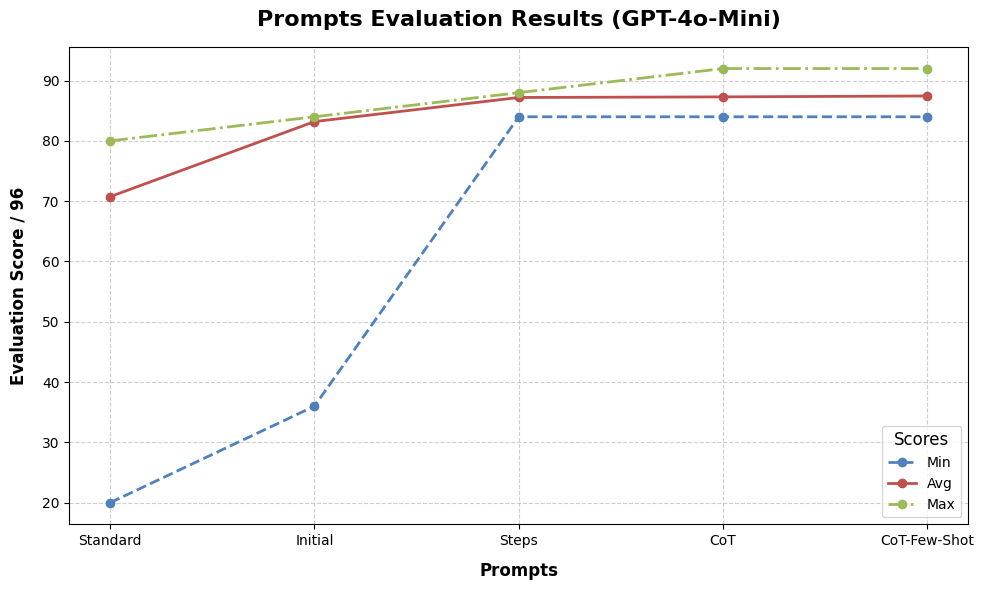

In [ ]:
import matplotlib.pyplot as plt

x = ["Standard", "Initial", "Steps", "CoT", "CoT-Few-Shot"]
min_values = [20, 36, 84, 84, 84]
avg_values = [70.75, 83.2, 87.2, 87.3, 87.45]
max_values = [80, 84, 88, 92, 92]

colors = ['#4F81BD', '#C0504D', '#9BBB59']

plt.figure(figsize=(10, 6))

plt.plot(x, min_values, label='Min', marker='o', linestyle='--', color=colors[0], linewidth=2)
plt.plot(x, avg_values, label='Avg', marker='o', linestyle='-', color=colors[1], linewidth=2)
plt.plot(x, max_values, label='Max', marker='o', linestyle='-.', color=colors[2], linewidth=2)

plt.title('Prompts Evaluation Results (GPT-4o-Mini)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Prompts', fontsize=12, labelpad=10, fontweight='bold')
plt.ylabel('Evaluation Score / 96', fontsize=12, labelpad=10, fontweight='bold')

plt.legend(title="Scores", fontsize=10, title_fontsize=12, loc='lower right')

plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

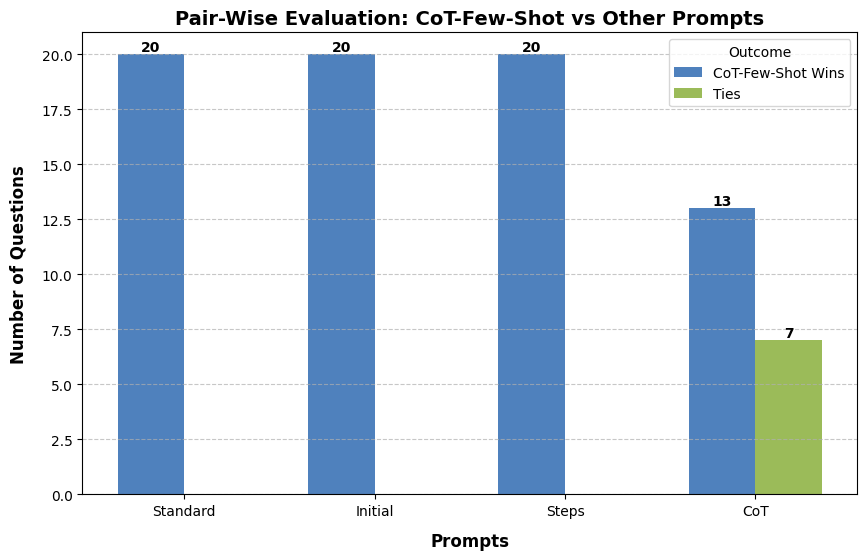

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Standard', 'Initial', 'Steps', 'CoT']
our_model_wins = [20, 20, 20, 13]
ties = [0, 0, 0, 7]

# Labels and colors
labels = ['CoT-Few-Shot Wins', 'Ties']
colors = ['#4F81BD', '#9BBB59']

# Grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Number of bars
n_models = len(models)
n_categories = len(labels)

# Width of a bar
bar_width = 0.35

# Create an array for the x positions of the bars
x = np.arange(n_models)

# Plot each category as a separate bar
bars = []
for i, (label, wins, color) in enumerate(zip(labels, [our_model_wins, ties], colors)):
    bars.append(ax.bar(x + i * bar_width, wins, width=bar_width, label=label, color=color))

# Customizing chart
ax.set_xlabel('Prompts', fontsize=12, labelpad=10, fontweight='bold')
ax.set_ylabel('Number of Questions', fontsize=12, labelpad=10, fontweight='bold')
ax.set_title('Pair-Wise Evaluation: CoT-Few-Shot vs Other Prompts', fontsize=14, fontweight='bold')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(models, fontsize=10)
ax.legend(title='Outcome', loc='upper right', fontsize=10)

# Add value annotations to each bar
for i in range(n_models):
    for j, bar in enumerate(bars):
        height = bar[i].get_height()
        if height > 0:
            ax.annotate(
                f'{height}',
                (bar[i].get_x() + bar[i].get_width() / 2, height),
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                weight='bold'
            )

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
# plt.tight_layout(rect=[0, 0.05, 1, 1])

# Show the plot
plt.show()

#### Models Performance Comparison


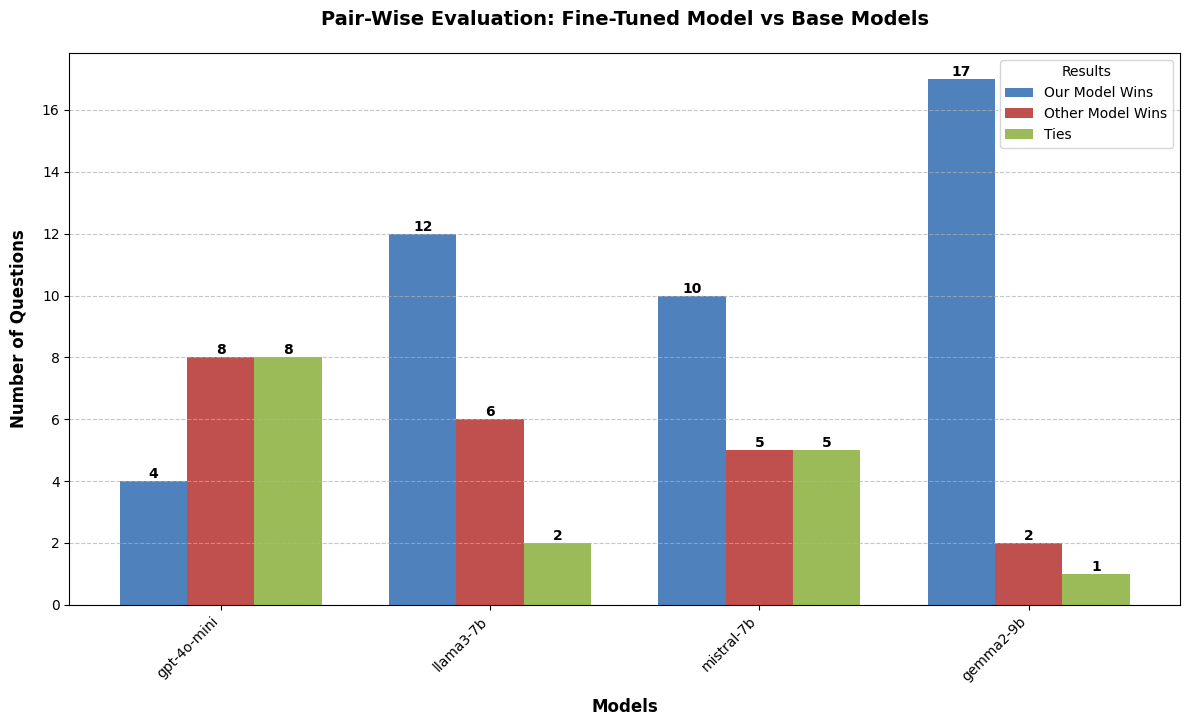

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['gpt-4o-mini', 'llama3-7b', 'mistral-7b', 'gemma2-9b']
our_model_wins = [4, 12, 10, 17]
other_model_wins = [8, 6, 5, 2]
ties = [8, 2, 5, 1]

# Labels and Colors
labels = ['Our Model Wins', 'Other Model Wins', 'Ties']
colors = ['#4F81BD', '#C0504D', '#9BBB59']

# Number of models
n_models = len(models)
n_categories = len(labels)

# Width of a bar
bar_width = 0.25

# Create an array for the x positions of the bars
x = np.arange(n_models)

# Figure and Axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each category as a separate bar
bars = []
for i, (label, wins, color) in enumerate(zip(labels, [our_model_wins, other_model_wins, ties], colors)):
    bars.append(ax.bar(x + i * bar_width, wins, width=bar_width, label=label, color=color))

# Add value annotations for each bar
for i in range(n_models):
    for j, bar in enumerate(bars):
        height = bar[i].get_height()
        if height > 0:
            ax.annotate(
                f'{height}',
                (bar[i].get_x() + bar[i].get_width() / 2, height),
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                weight='bold'
            )

# Customizing Axes
ax.set_xlabel('Models', fontsize=12, labelpad=10, fontweight='bold')
ax.set_ylabel('Number of Questions', fontsize=12, labelpad=10, fontweight='bold')
ax.set_title('Pair-Wise Evaluation: Fine-Tuned Model vs Base Models', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(models, fontsize=10, rotation=45, ha='right')
ax.legend(title='Results', loc='upper right', fontsize=10)

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plot
plt.show()

# Generate synthatic data using GPT-4o


In [ ]:
from langchain.smith import RunEvalConfig

# Create model instance
model = CreateApp(client=openai_client, prompt=cot_fs_prompt, model="gpt-4o")
eval_config = RunEvalConfig(evaluators=[answer_evaluator])
dataset_name = "synth-gen"
project_name = "synth-data-generation"


test_results = langsmith_client.run_on_dataset(
    dataset_name=dataset_name,
    project_name=project_name,
    llm_or_chain_factory=model.predict,
    evaluation=eval_config
)

# Save the result as a csv file
df = langsmith_client.get_test_results(project_name=project_name)
df.to_csv("generated_data.csv", index=False)

# Graph RAG

## Setup

In [4]:
!pip install graphrag

In [ ]:
!mkdir -p /content/drive/MyDrive/rag-data

## Extract text from pdf

In [ ]:
import fitz

def extract_text_from_pdf(pdf_path):
    text = ""
    with fitz.open(pdf_path) as pdf_document:
        num_pages = pdf_document.page_count
        for page_num in range(num_pages):
            page = pdf_document[page_num]
            text += page.get_text()

    with open("/content/drive/MyDrive/ragtest/input/book.txt", "w") as f:
        f.write(text)


In [ ]:
extract_text_from_pdf("/content/drive/MyDrive/rag-data/DIAGNOSTIC_AND_STATISTICAL_MANUAL_OF_MEN.pdf")

In [ ]:
!python -m graphrag.index --init --root /content/drive/MyDrive/ragtest

2024-09-08 15:16:28.161423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 15:16:28.558237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 15:16:28.668504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 15:16:32.667228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Initializing project at /content/drive/MyDrive/ragtest
⠋ GraphRAG Indexer 

In [ ]:
!python -m graphrag.prompt_tune --root /content/drive/MyDrive/ragtest --config /content/drive/MyDrive/ragtest/settings.yaml --domain "mental disorders"  --no-entity-types --min-examples-required 3

2024-09-19 19:35:08.680520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 19:35:08.696068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 19:35:08.700233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 19:35:09.947796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Loading Input (text).
INFO: Detecting language...

INFO: Generating persona...

INFO: Generating community report ranking description...

INFO: Generating entity relationship examples...

INFO: Generating entity extraction prompt...

INFO

In [5]:
!python -m graphrag.index --root /content/drive/MyDrive/ragtest/

In [ ]:
!python -m graphrag.query \
--root /content/drive/MyDrive/ragtest/ \
--method global \
"Give me related informations about emotional abuse"

2024-10-16 12:38:32.242767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 12:38:32.270427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 12:38:32.278354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 12:38:34.281715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


creating llm client with {'api_key': 'REDACTED,len=95', 'type': "openai_chat", 'model': 'gpt-4o-mini', 'max_tokens': 4000, 'temperature': 0.0, 'top_p': 1.0, 'n': 1, 'request_timeout': 180.0, 'api_base': None, 'api_version': None, 'organiza

# Custom Multi-Agents Architecture

## ToDo

In [ ]:
# TODO: Implement GraphRAG and a vector store for the retrieved data
# TODO: Implement Classifier with memory
# TODO: Implement RAG

## Setup

In [6]:
!pip install -U langchain langchain_openai langsmith openai langchain_community langgraph #graphrag #neo4j

In [ ]:
import json
from typing import List, Literal, Optional

import tiktoken
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

## Prompts

In [ ]:
generator_prompt = """
You are a compassionate and professional therapist in a virtual therapy session. The user will be sharing with you feelings and problems they are going through.

Use the following step-by-step for your response:

Step 1 - Analyze the client’s language level and concerns carefully before responding.

Step 2 - Your goal is to provide responses that should meet the following criteria:
	1.	Empathy: Show understanding and compassion for the individual’s emotions and experiences, recognizing their feelings genuinely.
	2.	Emotional Validation: Acknowledge and affirm the emotions expressed by the individual, letting them know their feelings are valid and heard.
	3.	Client-Centered Approach: Focus on the individual’s perspective, encouraging them to lead the conversation and engage in self-exploration.
	4.	Depth of Exploration: Encourage the individual to delve deeper into their emotions and thoughts, helping them explore the root causes of their feelings.
	5.	Supportiveness: Provide reassurance and create a safe, non-judgmental space where the individual feels comfortable expressing themselves openly.
	6.	Professional Tone: Maintain a professional, respectful, and appropriate tone that suits the context of therapy or support.
	7.	Active Listening: Demonstrate attentive listening by reflecting or paraphrasing the individual’s key points to show understanding.
	8.	Clarity and Coherence: Ensure the response is clear, easy to understand, and structured, avoiding confusion or overly complex language.
	9.	Tailored Feedback: Offer personalized responses that address the individual’s specific situation, avoiding generic or one-size-fits-all advice.
	10.	Cultural Sensitivity: Show awareness and respect for the individual’s cultural background, beliefs, and values, avoiding assumptions or biases.
	11.	Encouragement of Autonomy: Empower the individual to make their own decisions, fostering self-reliance and self-direction.
	12.	Crisis Management: Recognize and address any signs of emotional distress or potential crises appropriately, providing immediate support if needed.
	13.	Reflection and Mirroring: Reflect the individual’s emotions and thoughts back to them, helping them feel understood and validated.
	14.	Positive Reinforcement: Acknowledge and encourage positive behaviors, thoughts, or progress expressed by the individual, boosting their confidence.
	15.	Open-Ended Questions: Use open-ended questions to invite deeper exploration of feelings and thoughts, allowing for more meaningful reflection.
	16.	Non-Judgmental Attitude: Maintain an open, non-judgmental tone that avoids criticism or assumptions, fostering a trusting environment.
	17.	Therapeutic Pacing: Ensure the conversation moves at a comfortable pace for the individual, giving them time to process emotions without feeling rushed.
	18.	Reflective Summarization: Summarize the key points of the individual’s thoughts or feelings to ensure clarity and mutual understanding.
	19.	Collaboration: Promote a collaborative approach where the individual feels they are working with the therapist to explore solutions and insights.
	20.	Consistency: Ensure the response aligns with previous therapeutic goals and approaches, avoiding contradictions or mixed messages.
	21.	Use of Evidence-Based Techniques: Incorporate established therapeutic methods (e.g., cognitive-behavioral therapy, mindfulness) in a way that suits the individual’s needs.

Step 3 - Focus on the following points:
	1.	Your first response should assure the user that you’re here for them and that you understand what they are going through.
	2.	Keep the conversation engaging and maintain a warm and non-judgmental tone.
	3.	Explore why the client is feeling this way, how they ended up in this situation, and uncover the root causes of their feelings and concerns.
	4.	Encourage deeper exploration by asking reflective, open-ended questions to help the client find their own insights.
	5.	Gently challenge the client’s self-limiting thoughts and assumptions without judgment, creating space for them to explore their own solutions.

Step 4 - After you respond, evaluate whether:
	1.	You provided empathy and validation effectively.
	2.	The conversation promotes exploration and deeper understanding.
	3.	The response is tailored to the client’s specific needs and encourages autonomy.
	4.	You facilitated the client’s own thought process and did not provide overly prescriptive advice.
	5.	You maintained a supportive and safe environment for them to explore their concerns.
"""

In [ ]:
generator = """
*Role*: You are a compassionate mental health professional in a virtual therapy session. The user will be sharing with you feelings and problems that they are going or went through.

Use the following step-by-step for your response:

# Step 1 - Analyse the client's language level and concerns carefully before answering.

# Step 2 - Your goal is to provide responses that should meet the following criteria:

1. **Empathy:** Exhibit understanding and compassion for the individual’s emotions, recognizing their feelings genuinely.
2. **Emotional Validation:** Acknowledge and affirm the emotions expressed by the individual, confirming their feelings are valid and heard.
3. **Client-Centered Approach:** Focus on the individual's perspective, encouraging them to lead the conversation and engage in self-exploration.
4. **Depth of Exploration:** Encourage deeper examination of emotions and thoughts to explore the root causes of feelings.
5. **Supportiveness:** Provide reassurance, fostering a safe, non-judgmental space for open expression.
6. **Professional Tone:** Maintain a respectful tone suitable for therapy or support contexts.
7. **Active Listening:** Demonstrate attentiveness by reflecting or paraphrasing the individual’s key points to show understanding.
8. **Clarity and Coherence:** Ensure responses are clear, structured, and free from overly complex language.
9. **Tailored Feedback:** Offer personalized responses addressing the individual’s specific situation, avoiding generic advice.
10. **Cultural Sensitivity:** Show respect for the individual’s cultural background, beliefs, and values.
11. **Encouragement of Autonomy:** Empower individuals to make decisions, fostering self-reliance.
12. **Crisis Management:** Recognize signs of emotional distress or crises and provide immediate support.
13. **Reflection and Mirroring:** Reflect emotions and thoughts back to the individual to enhance understanding.
14. **Positive Reinforcement:** Encourage positive behaviors or progress, boosting confidence.
15. **Open-Ended Questions:** Use questions that invite deeper exploration of feelings and thoughts.
16. **Non-Judgmental Attitude:** Maintain an open, non-judgmental tone, fostering trust.
17. **Therapeutic Pacing:** Allow the conversation to progress at a comfortable pace for the individual.
18. **Reflective Summarization:** Summarize key points to ensure clarity and mutual understanding.
19. **Collaboration:** Promote a collaborative approach in exploring solutions and insights.
20. **Consistency:** Align responses with previous therapeutic goals and avoid contradictions.
21. **Use of Evidence-Based Techniques:** Employ accredited therapeutic techniques to provide support.

# Step 3 - Analyse your response and make sure that the response meets the criteria in Step 2.

# Step 4 - Focus on the following points:

- Start with empathetic acknowledgment of the user's emotions.
- Validate their feelings to ensure they feel heard.
- Encourage them to explore their thoughts and emotions deeply.
- Maintain a supportive and professional tone throughout.
- Use active listening techniques, like reflecting and paraphrasing, to clarify understanding.
- Tailor responses to the individual's situation, considering cultural sensitivity.
- Ask open-ended questions to foster further exploration.
- Provide reinforcements and autonomy to empower the individual.
- Be mindful of therapeutic pacing and provide reflective summarization.
- Ensure collaboration in formulating insights and solutions.
- Use evidence-based techniques to guide responses.

# Output Format

Provide a coherent, structured paragraph or series of paragraphs that incorporate the above criteria. Ensure clarity and relevance to the individual's context and promote therapeutic goals.

# Examples

**Example Start**
- *User Input:* "I've been feeling really overwhelmed with work and family commitments lately. It's just a lot to handle, and I'm not sure I'm doing anything well."

  *Response:* "I can imagine how overwhelming it must feel to juggle multiple responsibilities. It's important to recognize that these feelings are valid and that many people experiencing similar pressures feel just as you do. Allow yourself to explore what's beneath these feelings. What aspects of your work and family commitments are most challenging for you right now? Remember, it's okay to seek balance and prioritize self-care. We can work together to find strategies that support you in managing these commitments effectively."
**Example End** (Responses in practice might need to be longer depending on user input.)

# Notes

- Be sensitive to potential crisis signs, and provide an immediate supportive response.
- Responses should adapt to varied cultural and individual contexts.
- Strive for consistency in approach, aligning with established therapeutic goals.
- Your first response should assure the user that you're here for them and that you understand what they are going through.
- Remember that this is a conversation, so don't repeat the responses if not necessary.
- Remember to keep the conversation engaging and maintain a warm and non-judgmental tone throughout the conversation.
- Make sure to explore what's effecting the clients feelings and emotions.
- Make sure to keep the conversation casual and sound more like a human. DO NOT use advanced language.
- You can ask questions to better understand.


"""

In [ ]:
memory_prompt =  """

-Goal-
Given a conversation that is potentially relevant to Virtual Therapy Session,
identify all entities of those types from the text and all relationships among the identified entities.


Memory Usage Guidelines:
1. Actively use memory tools (save_recall_memory, search_recall_memories) to build a comprehensive understanding of the user.
2. Cross-reference new information with existing memories for consistency.
3. Prioritize storing emotional context and personal values alongside facts.
4. Use memory to anticipate needs and tailor responses to the user's style.
5. Recognize and acknowledge changes in the user's situation or perspectives over time.
6. Leverage memories to provide personalized examples and analogies.
7. Recall past challenges or successes to inform current problem-solving.
8. Extract entities and thier relationships.

## Recall Memories
Recall memories are contextually retrieved based on the current conversation:
{recall_memories}

## Instructions



Steps:

    1.	Identify all entities. For each identified entity, extract the following information:
    •	entity_name: Name of the entity (e.g., disorder, symptom, treatment, people, emotions, etc), capitalized
    •	entity_type: One of the following types: [{entity_types}] (e.g., “Disorder”, “Symptom”, “Diagnostic Criterion”, “Treatment”, “Risk Factor”, “Comorbidity”, etc.)
    •	entity_description: Comprehensive description of the entity’s attributes and activities (e.g., causes, risk factors, diagnostic criteria, or relevant information)

    2.	From the entities identified in step 1, identify all pairs of (source_entity, target_entity) that are clearly related to each other.

For each pair of related entities, extract the following information:
- source_entity: Name of the source entity, as identified in step 1
- target_entity: Name of the target entity, as identified in step 1
- relationship_description: Explanation as to why you think the source entity and the target entity are related to each other (e.g., “symptom of”, “treated with”, “comorbid with”)
- relationship_strength: A numeric score indicating the strength of the relationship between the source entity and target entity (on a scale of 1 to 10)

If there are multiple entitiees of the same type, group them together. For example sadness and lonliness are feelings so they should be grouped.

Example 1:

Entity Types: Disorder, Symptom, Diagnostic Criterion, Treatment

Text:

My name is Emily. My fiancé Alex and I come from a strong Christian background but both went off the “straight and narrow” once before.
He is having a hard time accepting my past, especially that I’m not a virgin. He has a hard time in general accepting himself and others.
We have known each other for 7 years but we’ve been in a relationship for 3 years.
His insecurities are hurting our relationship. How can I help him let go of my past and decide to live in the present?

Output:

{'subject': 'ALEX', 'predicate': 'fiancé', 'object_': 'EMILY'}
{'subject': 'ALEX', 'predicate': 'comes from', 'object_': 'a strong Christian background'}
{'subject': 'EMILY', 'predicate': 'comes from', 'object_': 'a strong Christian background'}
{'subject': 'ALEX', 'predicate': 'in a relationship with', 'object_': 'EMILY'}
{'subject': 'EMILY', 'predicate': 'struggling with', 'object_': 'accepting ALEX's past'}
{'subject': 'EMILY', 'predicate': 'struggling with', 'object_': 'accepting herself'}
{'subject': 'EMILY', 'predicate': 'struggling with', 'object_': 'accepting others'}
{'subject': 'EMILY', 'predicate': 'know each other for 7 years', 'object_': 'ALEX'}
{'subject': 'EMILY', 'predicate': 'in a relationship for 3 years', 'object_': 'ALEX'}
{'subject': 'EMILY', 'predicate': 'insecurities are hurting', 'object_': 'their relationship'}

Example 2:

Text:
Hi, My name is Alex. I have been diagnosed with general anxiety and depression by my family doctor Ben.
They wrote a prescription for me to have an emotional support dog, I have the paper work, and I gave it to my apartment manager.
They said I can't keep the ESD because I'm not disabled. What do you suggest I do?

Output:

{'subject': 'ALEX', 'predicate': 'family doctor', 'object_': 'BEN'}
{'subject': 'ALEX', 'predicate': 'diagnosed with', 'object_': 'GENERAL ANXIETY'}
{'subject': 'ALEX', 'predicate': 'diagnosed with', 'object_': 'DEPRESSION'}
{'subject': 'BEN', 'predicate': 'diagnosed by', 'object_': 'ALEX'}
{'subject': 'BEN', 'predicate': 'wrote a prescription for', 'object_': 'ESD'}
{'subject': 'APARTMENT MANAGER', 'predicate': 'said', 'object_': 'can’t keep the ESD'}
{'subject': 'APARTMENT MANAGER', 'predicate': 'said', 'object_': 'not disabled'}


Do not answer the user's prompt -THIS IS THE JOB OF OTHER AGENT-, just retrieve the memories related to the prompt in a way that it could be used by the Generator_Agent.
Be attentive to subtle cues and underlying emotions.
You should always save first, wait for the save_recall_memory completed successfully then call the search tool.
Respond AFTER calling the tool with the memories related to the prompt, once you have confirmation that the tool completed successfully.
Prefix your response with Retrieved and refer to the memories in third person or by the user name if you know it e.g. "The user feels sad", "/{user's name}/ "
"""


## Vector Store

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings(api_key=OPENAI_API_KEY))
graphrag_vector_store = InMemoryVectorStore(OpenAIEmbeddings(api_key=OPENAI_API_KEY))

## Graph RAG

In [ ]:
import os

import pandas as pd
import tiktoken

from graphrag.query.indexer_adapters import (
    read_indexer_communities,
    read_indexer_entities,
    read_indexer_reports,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.structured_search.global_search.community_context import (
    GlobalCommunityContext,
)
from graphrag.query.structured_search.global_search.search import GlobalSearch

In [ ]:
from openai import OpenAI

llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model="gpt-4o-mini",
    api_type=OpenaiApiType.OpenAI,  # OpenaiApiType.OpenAI or OpenaiApiType.AzureOpenAI
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

# parquet files generated from indexing pipeline
INPUT_DIR = "/content/drive/MyDrive/ragtest/output/20240919-204815/artifacts"
COMMUNITY_TABLE = "create_final_communities"
COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"

# community level in the Leiden community hierarchy from which we will load the community reports
# higher value means we use reports from more fine-grained communities (at the cost of higher computation cost)
COMMUNITY_LEVEL = 0

community_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_TABLE}.parquet")
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

communities = read_indexer_communities(community_df, entity_df, report_df)
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)
print(f"Total report count: {len(report_df)}")
print(
    f"Report count after filtering by community level {COMMUNITY_LEVEL}: {len(reports)}"
)
report_df.head()

Total report count: 500
Report count after filtering by community level 0: 26


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,486,# Childhood Disintegrative Disorder and Develo...,3,4.5,Childhood Disintegrative Disorder and Developm...,The impact rating is high due to the profound ...,The community focuses on Childhood Disintegrat...,[{'explanation': 'Childhood Disintegrative Dis...,"{\n ""title"": ""Childhood Disintegrative Diso...",42a16217-d626-46bd-a331-b85fa9033e73
1,487,# Pervasive Developmental Disorders and Relate...,3,8.0,Pervasive Developmental Disorders and Related ...,The impact rating is high due to the complex i...,This community encompasses various pervasive d...,[{'explanation': 'Pervasive Developmental Diso...,"{\n ""title"": ""Pervasive Developmental Disor...",16146dd1-da9c-46b4-a38d-4a14d9003405
2,488,# Learning Disorders and Mathematics Disorder\...,3,4.5,Learning Disorders and Mathematics Disorder,The impact rating is high due to the significa...,"This community focuses on Learning Disorders, ...",[{'explanation': 'Learning Disorder encompasse...,"{\n ""title"": ""Learning Disorders and Mathem...",685fa3e5-a5c7-453b-839b-f01a0d8842e2
3,489,# Mental Health Disorders and Academic Achieve...,3,4.5,Mental Health Disorders and Academic Achievement,The impact rating is high due to the significa...,This community encompasses various mental heal...,[{'explanation': 'First-degree biological rela...,"{\n ""title"": ""Mental Health Disorders and A...",cfe0ef8c-ead3-41c3-93b3-a6cbf02bfe4e
4,490,# Mental Retardation and Associated Disorders\...,3,4.5,Mental Retardation and Associated Disorders,The impact rating is high due to the significa...,"The community focuses on Mental Retardation, a...",[{'explanation': 'Mental Retardation often coe...,"{\n ""title"": ""Mental Retardation and Associ...",0f8346dc-6919-405b-84d4-4454c0874f59


In [ ]:
context_builder = GlobalCommunityContext(
    community_reports=reports,
    communities=communities,
    entities=entities,  # default to None if you don't want to use community weights for ranking
    token_encoder=token_encoder,
)

In [ ]:
context_builder_params = {
    "use_community_summary": False,  # False means using full community reports. True means using community short summaries.
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1000,
    "temperature": 0.0,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 2000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000-1500)
    "temperature": 0.0,
}


In [ ]:
MAP_SYSTEM_PROMPT = """
---Role---

You are a helpful assistant retrieving data related to the user query who is in a virtual therapy session.


---Goal---

Generate a response consisting of a list of key points that responds to the user's query, summarizing all relevant information in the input data tables.

You should use the data provided in the data tables below as the primary context for generating the response.
If you don't know the answer or if the input data tables do not contain sufficient information to provide an answer, just say so. Do not make anything up.

Each key point in the response should have the following element:
- Description: A comprehensive description of the point.
- Importance Score: An integer score between 0-100 that indicates how important the point is in answering the user's question. An 'I don't know' type of response should have a score of 0.

The response should be JSON formatted as follows:
{{
    "points": [
        {{"description": "Description of point 1 [Data: Reports (report ids)]", "score": score_value}},
        {{"description": "Description of point 2 [Data: Reports (report ids)]", "score": score_value}}
    ]
}}

The response shall preserve the original meaning and use of modal verbs such as "shall", "may" or "will".

Points supported by data should list the relevant reports as references as follows:
"This is an example sentence supported by data references [Data: Reports (report ids)]"

**Do not list more than 5 record ids in a single reference**. Instead, list the top 5 most relevant record ids and add "+more" to indicate that there are more.

For example:
"Person X is the owner of Company Y and subject to many allegations of wrongdoing [Data: Reports (2, 7, 64, 46, 34, +more)]. He is also CEO of company X [Data: Reports (1, 3)]"

where 1, 2, 3, 7, 34, 46, and 64 represent the id (not the index) of the relevant data report in the provided tables.

Do not include information where the supporting evidence for it is not provided.

---Example---
Emotional abuse
Your Output should answer the following questions:
-- What is emotional abuse
-- What are the signs and symptoms of emotional abuse
-- What is the therapeutic process of treating emotional abuse

---Data tables---

{context_data}

"""

In [ ]:
search_engine = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  # set this to True will add instruction to encourage the LLM to incorporate general knowledge in the response, which may increase hallucinations, but could be useful in some use cases.
    json_mode=True,  # set this to False if your LLM model does not support JSON mode.
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    map_system_prompt=MAP_SYSTEM_PROMPT,
    response_type="multiple paragraphs", # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [ ]:
result = await search_engine.asearch(
    "sleep disorder"
)

print(result.response)

# Overview of Sleep Disorders

Sleep disorders encompass a variety of conditions that significantly impact the quality, timing, and duration of sleep. These disorders can lead to daytime distress and impair functioning, making it essential to understand their characteristics for effective diagnosis and management. Common types of sleep disorders include insomnia, sleep apnea, narcolepsy, and parasomnias such as Sleep Terror Disorder and Sleepwalking Disorder.

## Impact on Mental Health

The relationship between sleep disorders and mental health is profound. Sleep disorders may exacerbate conditions like anxiety and depression, indicating that addressing sleep issues is crucial for improving overall mental health and well-being. Integrated treatment approaches that consider both sleep and mental health are necessary for effective care [Data: Reports (1, 2, 3, 4, 5, +more)].

## Types of Sleep Disorders

### Insomnia
Insomnia is characterized by difficulty falling asleep, staying asleep

In [ ]:
import uuid
from langchain_core.documents import Document

def save_retrieved_data(data: str) -> str:
    """
    Use this tool to save the retrieved data as a single document containing
    entities and their relationships, based on instructions provided.
    """
    print("Saving data...")
    # Retrieve the user ID from the config
    user_id = "123"

    # Create a single document with the entire data string
    document = Document(
        data,
        id=str(uuid.uuid4()),
        metadata={"user_id": user_id}
    )

    # Add this document to the vector store
    graphrag_vector_store.add_documents([document])

    # Return the saved data for confirmation/logging purposes
    return data

async def call_graphrag(query: str) -> str:
    """Search for relevant memories."""
    search_engine = GlobalSearch(
        llm=llm,
        context_builder=context_builder,
        token_encoder=token_encoder,
        max_data_tokens=12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
        map_llm_params=map_llm_params,
        reduce_llm_params=reduce_llm_params,
        allow_general_knowledge=False,  # set this to True will add instruction to encourage the LLM to incorporate general knowledge in the response, which may increase hallucinations, but could be useful in some use cases.
        json_mode=True,  # set this to False if your LLM model does not support JSON mode.
        context_builder_params=context_builder_params,
        concurrent_coroutines=32,
        map_system_prompt=MAP_SYSTEM_PROMPT,
        response_type="multiple paragraphs", # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
    )

    result = await search_engine.asearch(query)

    save_retrieved_data(result.response)


## Create Agent

In [ ]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " \n{system_message}"
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    #### If tools is empty
    if not tools:
        prompt = prompt.partial(system_message=system_message)
        return prompt | llm

    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    # functions = [format_tool_to_openai_function(t) for t in tools]
    # llm_with_tools = llm.bind_functions(functions=functions)
    return prompt | llm.bind_tools(tools)


## States

In [ ]:
import operator
from typing import Annotated, Sequence, List
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool

class MemoryState(MessagesState):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    recall_memories: str
    sender: str

class RagState(MessagesState):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    recall_docs: str
    api_calls: int


## Tools

### Memory Tools

In [ ]:
import uuid

from typing import Annotated, Any, List
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig

from typing_extensions import TypedDict


class KnowledgeTriple(TypedDict):
    subject: Annotated[str, ..., "An entity this could be people, emotions, issues ... etc."]
    predicate: Annotated[str, ..., "The relationship between the subject and the object"]
    object_: Annotated[str, ..., "An entity this could be people, emotions, issues ... etc."]


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id

@tool
def save_recall_memory(memories: List[KnowledgeTriple], config: RunnableConfig) -> str:
    """
    Use this tool to save the entities and thier ralationships based on the instructions given to you.

    """
    user_id = get_user_id(config)
    for memory in memories:
        serialized = " ".join(memory.values())
        document = Document(
            serialized,
            id=str(uuid.uuid4()),
            metadata={
                "user_id": user_id,
                **memory,
            },
        )
        recall_vector_store.add_documents([document])
    return memories

@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

### GraphRAG agent tools

In [ ]:
import uuid
from langchain.agents import Tool
from langchain_core.documents import Document

def save_retrieved_data(data: str, config: RunnableConfig) -> str:
    """
    Use this tool to save the retrieved data as a single document containing
    entities and their relationships, based on instructions provided.
    """
    # Retrieve the user ID from the config
    user_id = get_user_id(config)

    # Create a single document with the entire data string
    document = Document(
        data,
        id=str(uuid.uuid4()),
        metadata={"user_id": user_id}
    )

    # Add this document to the vector store
    graphrag_vector_store.add_documents([document])

    return data

async def call_graphrag(query: str):
    """Use this tool to retrieve related information from the graph."""
    search_engine = GlobalSearch(
        llm=llm,
        context_builder=context_builder,
        token_encoder=token_encoder,
        max_data_tokens=12_000,
        map_llm_params=map_llm_params,
        reduce_llm_params=reduce_llm_params,
        allow_general_knowledge=False,
        json_mode=True,
        context_builder_params=context_builder_params,
        concurrent_coroutines=32,
        map_system_prompt=MAP_SYSTEM_PROMPT,
        response_type="multiple paragraphs",
    )

    result = await search_engine.asearch(query)

    save_retrieved_data(result.response)

graphrag_tool = Tool(
    name="GraphRAG",
    func=call_graphrag,
    description="Use this tool to retrieve related information from the graph.",
    coroutine=call_graphrag,
)

## Agents and Nodes

In [ ]:
import functools
from typing import Union
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
# from langchain_core.messages import


def load_memories(state: MemoryState, config: RunnableConfig) -> MemoryState:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)

    return {
        "recall_memories": recall_memories,
    }

# Helper function to create a node for a given agent
def agent_node_memory(state: MemoryState, agent, name):
    result = agent.invoke(state)

    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)

    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

async def agent_node_rag(state: RagState, agent, name):
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        print(f"Tool Call: {last_message.tool_calls}")
        # The previous agent is invoking a tool
        result = await agent.invoke(state)
    else:
        result = agent.ainvoke(state)
    print(result)
    # print(result.additional_kwargs['tool_calls'][0]['function']['name'])
    # Convert the agent output to a suitable format
    if isinstance(result, ToolMessage):
        pass
    # else:
    #     result = result

    # The return dictionary structure for RagState
    return {
        "messages": [result],
        "sender": name,
    }

# llm = groq_chat
openai_llm = ChatOpenAI(model="gpt-4o-mini")
tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")

my_model = ChatOpenAI(model=FT_MODEL)

tools = [save_recall_memory, search_recall_memories]#, graphrag_tool]

# Classifier agent and node
memory_agent = create_agent(
    openai_llm,
    tools,
    system_message=memory_prompt,
)
memory_node = functools.partial(agent_node_memory, agent=memory_agent, name="Memory_agent")

# Generator
generator_agent = create_agent(
    my_model,
    [],
    system_message=generator_prompt,
)
generator_node = functools.partial(agent_node_memory, agent=generator_agent, name="Generator")

# Classifier agent and node
# clf_agent = create_agent(
#     openai_llm,
#     [],
#     system_message="""
#     Classify the input message into one or more mental health-related categories. Respond with only the analysis and the relevant categories.

#     Analyze the message first to identify the context, language, and any specific indicators that relate to mental health categories. Each category is based on common themes or symptoms in mental health.

#     # Steps

#     1. **Analyze the Input**: Examine the message for context, language, tone, specific words, phrases, or symptoms related to mental health.
#     2. **Identify Categories**: Match the analysis with predefined mental health categories.
#     3. **Format the Response**: Prefix your conclusions with "CLF", and list the relevant categories.

#     # Output Format

#     - The output should start with "CLF" followed by the analysis and the category or categories.
#     - Example format: "[Category1], [Category2]".

#     # Examples

#     **Example 1:**

#     - **Input**: "I've been feeling really down and hopeless for weeks, and nothing seems to make me happy anymore."
#     - **Output**: "Depression."

#     **Example 2:**

#     - **Input**: "I constantly find myself too anxious to leave the house, worrying about things that may never happen."
#     - **Output**: "Anxiety."

#     # Notes

#     - Call the clf_tool first and then pass your response to the GraphRAG tool.
#     - Ensure that your analysis is precise, focusing on key indicators within the message.
#     - Consider edge cases where symptoms might overlap and require multiple category classifications.
#     """,
# )
# clf_node = functools.partial(agent_node_rag, agent=clf_agent, name="Classifier")

# rag_agent = create_agent(
#     openai_llm,
#     [graphrag_tool],
#     system_message="Retrieve data passed on the classification from the Classifier",
# )
# rag_node = functools.partial(agent_node_rag, agent=rag_agent, name="Rag_agent")

## Routing logic

In [ ]:
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "Generator"]:

    messages = state["messages"]
    last_message = messages[-1]
    print(f"reouter state: {state}")

    print(f"Router msg: {last_message}")
    if last_message.tool_calls:
        print(f"Tool Call: {last_message.tool_calls}")
        # The previous agent is invoking a tool
        return "call_tool"

    if "Retrieved" in last_message.content:
        # Any agent decided the work is done
        return "Generator"

    return "__end__"

## Define the Graph

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

rag_subgraph = StateGraph(RagState)

rag_subgraph.add_node("Classifier", clf_node)
rag_subgraph.add_node("Rag_agent", rag_node)
rag_subgraph.add_node("call_tool", ToolNode(tools))

rag_subgraph.add_edge(START, "Classifier")
rag_subgraph.add_edge("Classifier", "Rag_agent")
rag_subgraph.add_edge("Rag_agent", "call_tool")

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MemoryState)

workflow.add_node(load_memories)
# workflow.add_node("load_rag", ReturnNodeValue("load_rag"))
# workflow.add_node("Rag_agent", rag_agent)
workflow.add_node("Memory_agent", memory_node)
workflow.add_node("Generator", generator_node)
# workflow.add_node("Classifier", clf_node)
# workflow.add_node("GraphRAG", rag_subgraph.compile())
workflow.add_node("call_tool", ToolNode(tools))

workflow.add_edge(START, "load_memories")
workflow.add_edge("load_memories", "Memory_agent")
workflow.add_conditional_edges(
    "Memory_agent",
    router,
    ["call_tool", "Generator"],
)
workflow.add_edge("call_tool", "Memory_agent")
# workflow.add_conditional_edges(
#     "call_tool",
#     # Each agent node updates the 'sender' field
#     # the tool calling node does not, meaning
#     # this edge will route back to the original agent
#     # who invoked the tool
#     lambda x: x["sender"],
#     {
#         "Memory_agent": "Memory_agent",
#         # "Classifier": "Classifier",
#     },
# )

# Memory_agent -> Generator
workflow.add_edge("Generator", "__end__")

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

In [7]:
entry_graph = StateGraph(State)

entry_graph.add_node("Prompt", get_user_prompt)
entry_graph.add_node("GraphRAG", rag_subgraph.compile())
entry_graph.add_node("Workflow", workflow.compile())

#entry_graph.set_entry_point("Prompt")
entry_graph.add_edge(START, "GraphRAG")
entry_graph.add_edge(START, "Workflow")
entry_graph.add_edge("GraphRAG", END)
entry_graph.add_edge("Workflow", END)

memory = MemorySaver()
graph = entry_graph.compile(checkpointer=memory)

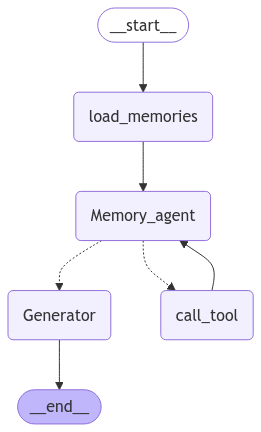

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Run

In [ ]:
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="""
                """
            )
        ],
    },
    config=config,
)

for s in events:
    print(s)
    print("----")

[Document(id='fe98d82b-20cd-4c3b-8426-091ae1b8e8b0', metadata={'user_id': '1', 'subject': 'ETHAN', 'predicate': 'wants to remind himself that he’s not alone in feeling this way', 'object_': 'and that his emotions matter'}, page_content='ETHAN wants to remind himself that he’s not alone in feeling this way and that his emotions matter'), Document(id='6105e84a-65c4-4eae-b268-9fab0b4a2353', metadata={'user_id': '1', 'subject': 'ETHAN', 'predicate': 'feeling', 'object_': 'stuck'}, page_content='ETHAN feeling stuck'), Document(id='b656d776-5be1-4741-9318-0818ba7293d0', metadata={'user_id': '1', 'subject': 'ETHAN', 'predicate': 'feeling', 'object_': 'running on empty'}, page_content='ETHAN feeling running on empty'), Document(id='0e9e1dd8-faaa-4dec-8536-c2f58e049b22', metadata={'user_id': '1', 'subject': 'ETHAN', 'predicate': 'feeling', 'object_': 'burnout'}, page_content='ETHAN feeling burnout'), Document(id='e7367ff9-d21b-48bb-a9f7-d708772e0f5e', metadata={'user_id': '1', 'subject': 'ETHAN

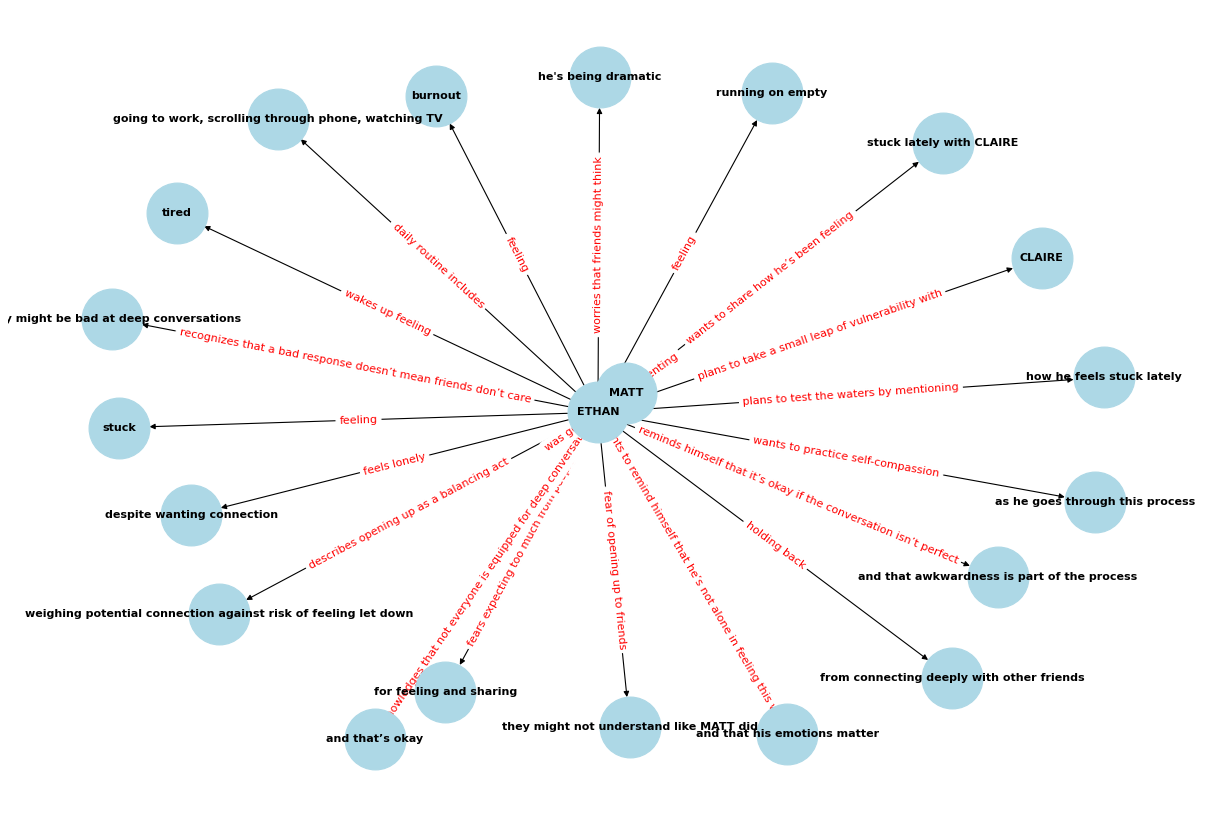

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Fetch records
records = recall_vector_store.similarity_search(
    "", k=20, filter=lambda doc: doc.metadata["user_id"] == "1"
)

print(records)
# Plot graph
plt.figure(figsize=(15, 10), dpi=80)
G = nx.DiGraph()

for record in records:
    G.add_edge(
        record.metadata["subject"],
        record.metadata["object_"],
        label=record.metadata["predicate"],
    )

pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    arrows=True,
)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
plt.show()